In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [3]:
train_df = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/train.csv', encoding='latin-1')
test_df = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/test.csv', encoding='latin-1')

In [4]:
train_df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [5]:
test_df.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


# Data Visualisation

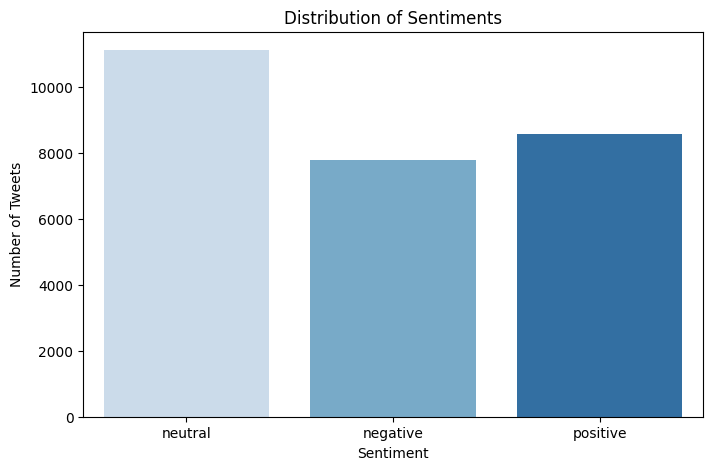

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Count Plot for Sentiment Distribution ---
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=train_df, palette='Blues')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

# Data Preprocessing

In [5]:
# Remove unnecessary columns
train_df.drop(columns=['textID', 'Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)'], inplace=True)
train_df.head()

,text,selected_text,sentiment
0,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,my boss is bullying me...,bullying me,negative
3,what interview! leave me alone,leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [6]:
# Remove unnecessary columns
test_df.drop(columns=['textID', 'Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)'], inplace=True)
test_df.head()

,text,sentiment
0,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely -...,positive
2,"Recession hit Veronique Branquinho, she has to...",negative
3,happy bday!,positive
4,http://twitpic.com/4w75p - I like it!!,positive


In [7]:
# Null values
train_df.dropna(subset=['selected_text'], inplace=True)
print(train_df.isna().sum())

text             0
selected_text    0
sentiment        0
dtype: int64


In [8]:
test_df.dropna(subset=['text'], inplace=True)
print(test_df.isna().sum())

text         0
sentiment    0
dtype: int64


In [ ]:
!pip install contractions

In [10]:
import re
import spacy
import contractions

# Prefer GPU if available
spacy.prefer_gpu()

# Load spaCy (disable NER for speed)
nlp = spacy.load("en_core_web_sm", disable=["ner"])

# Build stopword list (keep negations)
negations = {"no", "not", "never"}
STOP_WORDS = set(nlp.Defaults.stop_words) - negations

def clean_text(text: str) -> str:
    """Preprocess text for TF-IDF + classical ML models."""
    if not isinstance(text, str):
        return ""

    # 1) Expand contractions
    text = contractions.fix(text)

    # 2) Lowercase
    text = text.lower()

    # 3) Remove URLs & HTML
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)

    # 4) Remove unwanted characters (keep ! and ? for sentiment)
    text = re.sub(r'[^a-z\s!\?]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # 5) Lemmatize + remove stopwords
    doc = nlp(text)
    tokens = []
    for token in doc:
        if token.is_space:
            continue
        lemma = token.lemma_.lower() if token.lemma_ != "-PRON-" else token.lower_
        if lemma in STOP_WORDS or lemma.isnumeric():
            continue
        tokens.append(lemma)

    return " ".join(tokens)

In [11]:
train_df['cleaned_text'] = train_df['text'].astype(str).apply(clean_text)
test_df['cleaned_text'] = test_df['text'].astype(str).apply(clean_text)

In [12]:
# Encoding the labels in the train dataset
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_df['idx'] = label_encoder.fit_transform(train_df['sentiment'])
train_df.head()

,text,selected_text,sentiment,cleaned_text,idx
0,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,d respond,1
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad miss san diego ! ! !,0
2,my boss is bullying me...,bullying me,negative,boss bully,0
3,what interview! leave me alone,leave me alone,negative,interview ! leave,0
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,son couldn t release buy,0


In [13]:
# Encoding the labels in the test dataset
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
test_df['idx'] = label_encoder.fit_transform(test_df['sentiment'])
test_df.head()

,text,sentiment,cleaned_text,idx
0,Last session of the day http://twitpic.com/67ezh,neutral,session day,1
1,Shanghai is also really exciting (precisely -...,positive,shanghai exciting precisely skyscraper galore ...,2
2,"Recession hit Veronique Branquinho, she has to...",negative,recession hit veronique branquinho quit compan...,0
3,happy bday!,positive,happy birthday !,2
4,http://twitpic.com/4w75p - I like it!!,positive,like ! !,2


In [14]:
# Defining features and target
X = train_df['cleaned_text']
y = train_df['idx']

# Text Vectorization

### Tf-Idf

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), norm='l2')
X_vector_tfidf = vectorizer_tfidf.fit_transform(X)

### Bag Of Words (BoW)

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_bow = CountVectorizer(max_features=5000, stop_words="english")
X_vector_bow = vectorizer_bow.fit_transform(X)

### Word2Vec

In [17]:
tokenized_text = train_df['cleaned_text'].apply(lambda x: x.split())

In [18]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(sentences=tokenized_text,
                     vector_size=100,  
                     window=5,      
                     min_count=2,    
                     workers=4)      

In [20]:
import numpy as np

def create_document_vector(text, model):
    """Creates a single vector for a document by averaging its word vectors."""
    
    # Split the document's text into words
    words = text.split()
    
    # Get the vectors for only the words that exist in the Word2Vec model's vocabulary
    words_in_vocab = [word for word in words if word in model.wv.key_to_index]
    
    # If no words from the document are in the vocabulary, return a zero vector
    if not words_in_vocab:
        return np.zeros(model.vector_size)
    
    # Calculate the mean of the word vectors to get the document vector
    document_vector = np.mean([model.wv[word] for word in words_in_vocab], axis=0)
    return document_vector

In [21]:
X_vector_w2v = np.array([create_document_vector(text, w2v_model) for text in train_df['cleaned_text']])

# Final training and testing sets 

In [22]:
# For training set
X_train_tfidf_final = X_vector_tfidf
y_train_tfidf_final = train_df['idx'].values
# For testing set
X_test_tfidf_final = vectorizer_tfidf.transform(test_df['cleaned_text'])
y_test_tfidf_final = test_df['idx'].values

In [31]:
# For training set
X_train_bow_final = X_vector_bow
y_train_bow_final = train_df['idx'].values
# For testing set
X_test_bow_final = vectorizer_bow.transform(test_df['cleaned_text'])
y_test_bow_final = test_df['idx'].values

In [25]:
# For training set
X_train_w2v_final = X_vector_w2v
y_train_w2v_final = train_df['idx'].values
# For testing set
X_test_w2v_final = np.array([create_document_vector(text, w2v_model) for text in test_df['cleaned_text']])
y_test_w2v_final = test_df['idx'].values

# Logistic Regression

In [ ]:
# Hyperparameter Tuning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
model_lr = LogisticRegression()
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['saga']
}
grid_search = GridSearchCV(estimator=model_lr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_bow, y_train_bow)
print("\nBest hyperparameters found:")
print(grid_search.best_params_)

In [26]:
from sklearn.linear_model import LogisticRegression
model_lr_tfidf = LogisticRegression(C=1, penalty='l1', solver='saga', class_weight='balanced')
model_lr_tfidf.fit(X_train_tfidf_final, y_train_tfidf_final)

LogisticRegression(C=1, class_weight='balanced', penalty='l1', solver='saga')

In [27]:
from sklearn.metrics import classification_report, accuracy_score
y_pred_lr_tfidf = model_lr_tfidf.predict(X_test_tfidf_final)
print(f"Accuracy: {accuracy_score(y_test_tfidf_final, y_pred_lr_tfidf):.4f}")
print(classification_report(y_test_tfidf_final, y_pred_lr_tfidf, target_names=['negative', 'positive', 'neutral']))

Accuracy: 0.7326
              precision    recall  f1-score   support

    negative       0.72      0.74      0.73      1001
    positive       0.69      0.70      0.70      1430
     neutral       0.80      0.77      0.78      1103

    accuracy                           0.73      3534
   macro avg       0.74      0.74      0.74      3534
weighted avg       0.73      0.73      0.73      3534



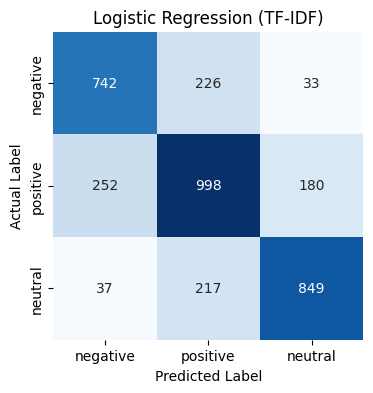

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_tfidf_final, y_pred_lr_tfidf)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive', 'neutral'], yticklabels=['negative', 'positive', 'neutral'], cbar=False)
plt.title('Logistic Regression (TF-IDF)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [32]:
model_lr_bow = LogisticRegression(C=1, penalty='l1', solver='saga', class_weight='balanced')
model_lr_bow.fit(X_train_bow_final, y_train_bow_final)

LogisticRegression(C=1, class_weight='balanced', penalty='l1', solver='saga')

In [33]:
from sklearn.metrics import classification_report, accuracy_score
y_pred_lr_bow = model_lr_bow.predict(X_test_bow_final)
print(f"Accuracy: {accuracy_score(y_test_bow_final, y_pred_lr_bow):.4f}")
print(classification_report(y_test_bow_final, y_pred_lr_bow, target_names=['negative', 'positive', 'neutral']))

Accuracy: 0.7139
              precision    recall  f1-score   support

    negative       0.69      0.71      0.70      1001
    positive       0.69      0.68      0.68      1430
     neutral       0.77      0.76      0.77      1103

    accuracy                           0.71      3534
   macro avg       0.72      0.72      0.72      3534
weighted avg       0.71      0.71      0.71      3534



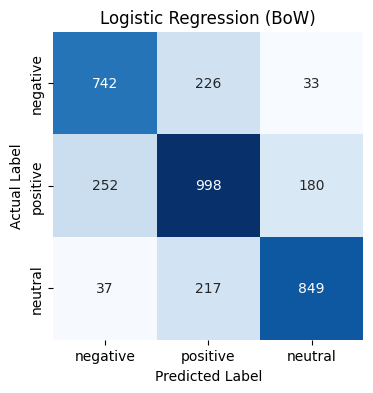

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_tfidf_final, y_pred_lr_tfidf)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive', 'neutral'], yticklabels=['negative', 'positive', 'neutral'], cbar=False)
plt.title('Logistic Regression (BoW)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [35]:
model_lr_w2v = LogisticRegression(C=1, penalty='l1', solver='saga')
model_lr_w2v.fit(X_train_w2v_final, y_train_w2v_final)

LogisticRegression(C=1, penalty='l1', solver='saga')

In [36]:
from sklearn.metrics import classification_report, accuracy_score
y_pred_lr_w2v = model_lr_w2v.predict(X_test_w2v_final)
print(f"Accuracy: {accuracy_score(y_test_w2v_final, y_pred_lr_w2v):.4f}")
print(classification_report(y_test_w2v_final, y_pred_lr_w2v, target_names=['negative', 'positive', 'neutral']))

Accuracy: 0.5889
              precision    recall  f1-score   support

    negative       0.63      0.39      0.48      1001
    positive       0.52      0.72      0.61      1430
     neutral       0.70      0.60      0.64      1103

    accuracy                           0.59      3534
   macro avg       0.62      0.57      0.58      3534
weighted avg       0.61      0.59      0.58      3534



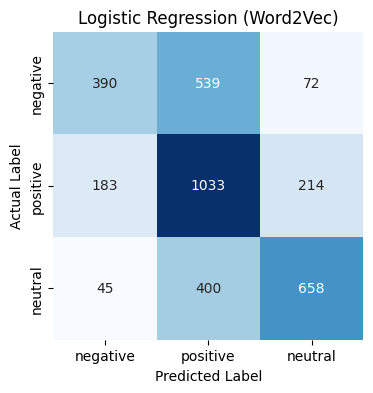

In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_w2v_final, y_pred_lr_w2v)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive', 'neutral'], yticklabels=['negative', 'positive', 'neutral'], cbar=False)
plt.title('Logistic Regression (Word2Vec)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# XGBoost Classifier

In [ ]:
# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid = {
    'n_estimators': [100, 200],         
    'max_depth': [3, 5, 7],               
    'learning_rate': [0.05, 0.1],       
    'subsample': [0.7, 1.0],              
    'colsample_bytree': [0.7, 1.0]      
}
random_search = RandomizedSearchCV(
    estimator=model_xgb,
    param_distributions=param_grid,
    n_iter=10,  
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy',
    random_state=42
)
random_search.fit(X_train_tfidf, y_train_tfidf)
print("\nBest hyperparameters found:")
print(random_search.best_params_)

In [38]:
from xgboost import XGBClassifier
model_xgb_tfidf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, subsample=1.0, n_estimators=200, max_depth=5, learning_rate=0.1, colsample_bytree=1.0)
model_xgb_tfidf.fit(X_train_tfidf_final, y_train_tfidf_final)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [39]:
y_pred_xgb_test_tfidf = model_xgb_tfidf.predict(X_test_tfidf_final)
print(f"Accuracy: {accuracy_score(y_test_tfidf_final, y_pred_xgb_test_tfidf):.4f}")
print(classification_report(y_test_tfidf_final, y_pred_xgb_test_tfidf, target_names=['negative', 'positive', 'neutral']))

Accuracy: 0.6890
              precision    recall  f1-score   support

    negative       0.76      0.52      0.62      1001
    positive       0.60      0.81      0.69      1430
     neutral       0.83      0.69      0.75      1103

    accuracy                           0.69      3534
   macro avg       0.73      0.67      0.68      3534
weighted avg       0.72      0.69      0.69      3534



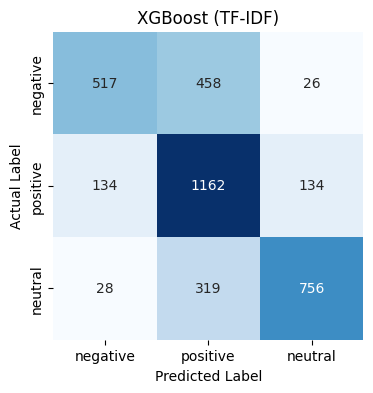

In [40]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_tfidf_final, y_pred_xgb_test_tfidf)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive', 'neutral'], yticklabels=['negative', 'positive', 'neutral'], cbar=False)
plt.title('XGBoost (TF-IDF)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [41]:
from xgboost import XGBClassifier
model_xgb_bow = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, subsample=1.0, n_estimators=200, max_depth=5, learning_rate=0.1, colsample_bytree=1.0)
model_xgb_bow.fit(X_train_bow_final, y_train_bow_final)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [42]:
y_pred_xgb_test_bow = model_xgb_bow.predict(X_test_bow_final)
print(f"Accuracy: {accuracy_score(y_test_bow_final, y_pred_xgb_test_bow):.4f}")
print(classification_report(y_test_bow_final, y_pred_xgb_test_bow, target_names=['negative', 'positive', 'neutral']))

Accuracy: 0.6822
              precision    recall  f1-score   support

    negative       0.75      0.51      0.61      1001
    positive       0.60      0.80      0.69      1430
     neutral       0.79      0.68      0.73      1103

    accuracy                           0.68      3534
   macro avg       0.71      0.67      0.68      3534
weighted avg       0.70      0.68      0.68      3534



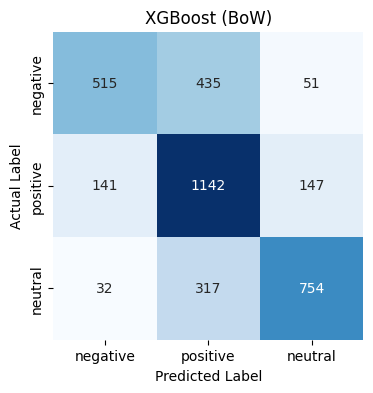

In [43]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_bow_final, y_pred_xgb_test_bow)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive', 'neutral'], yticklabels=['negative', 'positive', 'neutral'], cbar=False)
plt.title('XGBoost (BoW)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [44]:
from xgboost import XGBClassifier
model_xgb_w2v = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, subsample=1.0, n_estimators=200, max_depth=5, learning_rate=0.1, colsample_bytree=1.0)
model_xgb_w2v.fit(X_train_w2v_final, y_train_w2v_final)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [45]:
y_pred_xgb_test_w2v = model_xgb_w2v.predict(X_test_w2v_final)
print(f"Accuracy: {accuracy_score(y_test_w2v_final, y_pred_xgb_test_w2v):.4f}")
print(classification_report(y_test_w2v_final, y_pred_xgb_test_w2v, target_names=['negative', 'positive', 'neutral']))

Accuracy: 0.5815
              precision    recall  f1-score   support

    negative       0.55      0.42      0.48      1001
    positive       0.54      0.66      0.60      1430
     neutral       0.67      0.62      0.64      1103

    accuracy                           0.58      3534
   macro avg       0.59      0.57      0.57      3534
weighted avg       0.58      0.58      0.58      3534



# RandomForest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200],         
    'max_depth': [10, 20, None],          
    'min_samples_split': [2, 5],        
    'min_samples_leaf': [1, 2],         
    'bootstrap': [True]                 
}
gs_rf = GridSearchCV(
    estimator=model_rf,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=5,
    verbose=1,
    n_jobs=-1,
)

gs_rf.fit(X_train_tfidf, y_train_tfidf)
print("Best parameters found: ", gs_rf.best_params_)

In [46]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200, bootstrap=True)
model_rf.fit(X_train_tfidf_final, y_train_tfidf_final)

RandomForestClassifier(n_estimators=200)

In [47]:
y_pred_rf_test = model_rf.predict(X_test_tfidf_final)
print(f"Accuracy: {accuracy_score(y_test_tfidf_final, y_pred_rf_test):.4f}")
print(classification_report(y_test_tfidf_final, y_pred_rf_test, target_names=['negative', 'positive', 'neutral']))

Accuracy: 0.7173
              precision    recall  f1-score   support

    negative       0.73      0.68      0.70      1001
    positive       0.67      0.72      0.69      1430
     neutral       0.78      0.76      0.77      1103

    accuracy                           0.72      3534
   macro avg       0.72      0.72      0.72      3534
weighted avg       0.72      0.72      0.72      3534



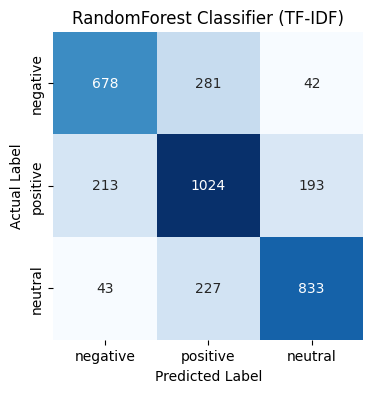

In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_tfidf_final, y_pred_rf_test)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive', 'neutral'], yticklabels=['negative', 'positive', 'neutral'], cbar=False)
plt.title('RandomForest Classifier (TF-IDF)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [49]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200, bootstrap=True)
model_rf.fit(X_train_bow_final, y_train_bow_final)

RandomForestClassifier(n_estimators=200)

In [50]:
y_pred_rf_test = model_rf.predict(X_test_bow_final)
print(f"Accuracy: {accuracy_score(y_test_bow_final, y_pred_rf_test):.4f}")
print(classification_report(y_test_bow_final, y_pred_rf_test, target_names=['negative', 'positive', 'neutral']))

Accuracy: 0.6964
              precision    recall  f1-score   support

    negative       0.67      0.66      0.67      1001
    positive       0.67      0.67      0.67      1430
     neutral       0.74      0.77      0.75      1103

    accuracy                           0.70      3534
   macro avg       0.70      0.70      0.70      3534
weighted avg       0.70      0.70      0.70      3534



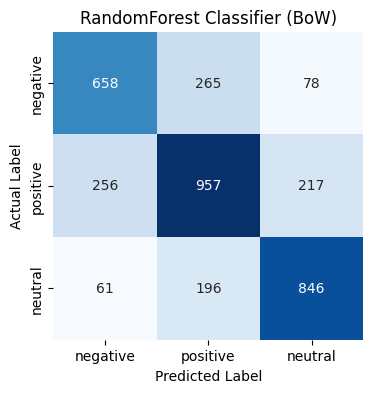

In [51]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_bow_final, y_pred_rf_test)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive', 'neutral'], yticklabels=['negative', 'positive', 'neutral'], cbar=False)
plt.title('RandomForest Classifier (BoW)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [52]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200, bootstrap=True)
model_rf.fit(X_train_w2v_final, y_train_w2v_final)

RandomForestClassifier(n_estimators=200)

In [53]:
y_pred_rf_test = model_rf.predict(X_test_w2v_final)
print(f"Accuracy: {accuracy_score(y_test_w2v_final, y_pred_rf_test):.4f}")
print(classification_report(y_test_w2v_final, y_pred_rf_test, target_names=['negative', 'positive', 'neutral']))

Accuracy: 0.5538
              precision    recall  f1-score   support

    negative       0.51      0.42      0.46      1001
    positive       0.52      0.61      0.57      1430
     neutral       0.64      0.60      0.62      1103

    accuracy                           0.55      3534
   macro avg       0.56      0.54      0.55      3534
weighted avg       0.55      0.55      0.55      3534



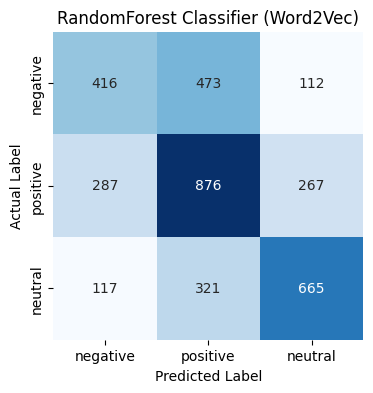

In [54]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_w2v_final, y_pred_rf_test)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive', 'neutral'], yticklabels=['negative', 'positive', 'neutral'], cbar=False)
plt.title('RandomForest Classifier (Word2Vec)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# SVM

In [ ]:
# Hyperparameter Tuning with RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

model_svm = SVC()

param_dist = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

random_search = RandomizedSearchCV(
    estimator=model_svm,
    param_distributions=param_dist,
    n_iter=10,                 
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy',
    random_state=42
)

random_search.fit(X_train_tfidf, y_train_tfidf)

print(random_search.best_params_)

In [55]:
from sklearn.svm import SVC
model_svm = SVC(kernel='linear', gamma=0.001, C=1)
model_svm.fit(X_train_tfidf_final, y_train_tfidf_final)

SVC(C=1, gamma=0.001, kernel='linear')

In [56]:
y_pred_svm_test = model_svm.predict(X_test_tfidf_final)
print(f"Accuracy: {accuracy_score(y_test_tfidf_final, y_pred_svm_test):.4f}")
print(classification_report(y_test_tfidf_final, y_pred_svm_test, target_names=['negative', 'positive', 'neutral']))

Accuracy: 0.7247
              precision    recall  f1-score   support

    negative       0.74      0.68      0.71      1001
    positive       0.66      0.75      0.70      1430
     neutral       0.82      0.73      0.77      1103

    accuracy                           0.72      3534
   macro avg       0.74      0.72      0.73      3534
weighted avg       0.73      0.72      0.73      3534



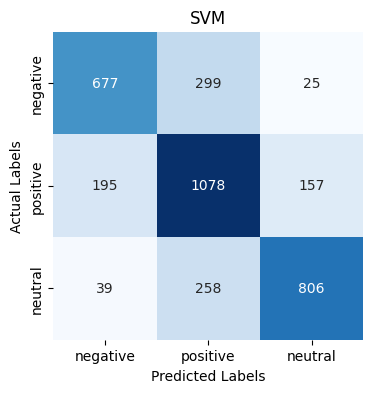

In [57]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_tfidf_final, y_pred_svm_test)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive', 'neutral'], yticklabels=['negative', 'positive', 'neutral'], cbar=False)
plt.title('SVM')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [58]:
from sklearn.svm import SVC
model_svm = SVC(kernel='linear', gamma=0.001, C=1)
model_svm.fit(X_train_bow_final, y_train_bow_final)

SVC(C=1, gamma=0.001, kernel='linear')

In [59]:
y_pred_svm_test = model_svm.predict(X_test_bow_final)
print(f"Accuracy: {accuracy_score(y_test_bow_final, y_pred_svm_test):.4f}")
print(classification_report(y_test_bow_final, y_pred_svm_test, target_names=['negative', 'positive', 'neutral']))

Accuracy: 0.7156
              precision    recall  f1-score   support

    negative       0.71      0.67      0.69      1001
    positive       0.67      0.73      0.70      1430
     neutral       0.79      0.74      0.76      1103

    accuracy                           0.72      3534
   macro avg       0.72      0.71      0.72      3534
weighted avg       0.72      0.72      0.72      3534



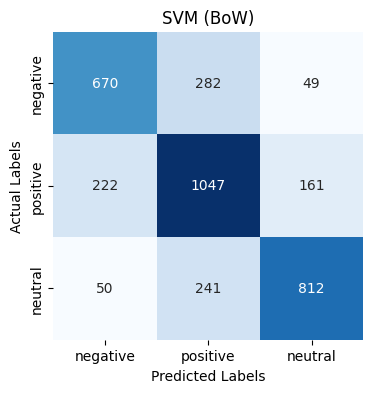

In [60]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_bow_final, y_pred_svm_test)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive', 'neutral'], yticklabels=['negative', 'positive', 'neutral'], cbar=False)
plt.title('SVM (BoW)')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [61]:
from sklearn.svm import SVC
model_svm = SVC(kernel='linear', gamma=0.001, C=1)
model_svm.fit(X_train_w2v_final, y_train_w2v_final)

SVC(C=1, gamma=0.001, kernel='linear')

In [62]:
y_pred_svm_test = model_svm.predict(X_test_w2v_final)
print(f"Accuracy: {accuracy_score(y_test_w2v_final, y_pred_svm_test):.4f}")
print(classification_report(y_test_w2v_final, y_pred_svm_test, target_names=['negative', 'positive', 'neutral']))

Accuracy: 0.5631
              precision    recall  f1-score   support

    negative       0.67      0.22      0.33      1001
    positive       0.50      0.82      0.62      1430
     neutral       0.71      0.54      0.62      1103

    accuracy                           0.56      3534
   macro avg       0.63      0.53      0.52      3534
weighted avg       0.61      0.56      0.54      3534



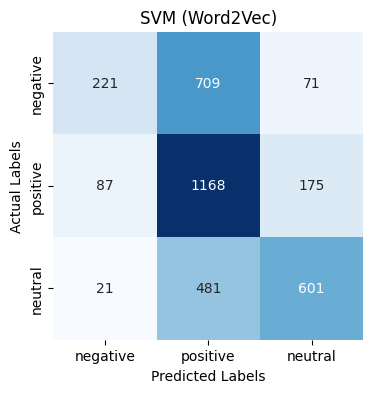

In [63]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_w2v_final, y_pred_svm_test)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive', 'neutral'], yticklabels=['negative', 'positive', 'neutral'], cbar=False)
plt.title('SVM (Word2Vec)')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# KNN

In [ ]:
# Hyperparameter Tuning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

model_knn = KNeighborsClassifier()

param_dist = {
    'n_neighbors': list(range(1, 31)),  
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

random_search_knn = RandomizedSearchCV(
    estimator=model_knn,
    param_distributions=param_dist,
    n_iter=20,                 # number of random combos to try
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy',
    random_state=42
)

random_search_knn.fit(X_train_tfidf, y_train_tfidf)

print("\nBest hyperparameters found (KNN):")
print(random_search_knn.best_params_)

In [64]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(weights='distance', n_neighbors=3, metric='cosine')
model_knn.fit(X_train_tfidf_final, y_train_tfidf_final)

KNeighborsClassifier(metric='cosine', n_neighbors=3, weights='distance')

In [65]:
y_pred_knn_test = model_knn.predict(X_test_tfidf_final)
print(f"Accuracy: {accuracy_score(y_test_tfidf_final, y_pred_knn_test):.4f}")
print(classification_report(y_test_tfidf_final, y_pred_knn_test, target_names=['negative', 'positive', 'neutral']))

Accuracy: 0.5439
              precision    recall  f1-score   support

    negative       0.53      0.46      0.49      1001
    positive       0.51      0.63      0.56      1430
     neutral       0.63      0.51      0.56      1103

    accuracy                           0.54      3534
   macro avg       0.55      0.53      0.54      3534
weighted avg       0.55      0.54      0.54      3534



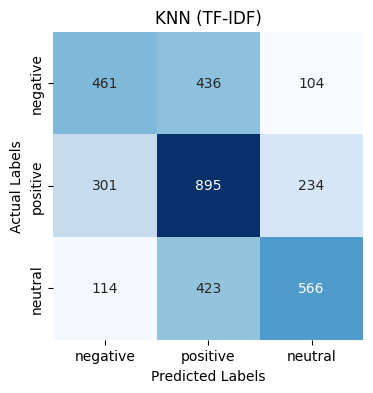

In [66]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_tfidf_final, y_pred_knn_test)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive', 'neutral'], yticklabels=['negative', 'positive', 'neutral'], cbar=False)
plt.title('KNN (TF-IDF)')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [67]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(weights='distance', n_neighbors=3, metric='cosine')
model_knn.fit(X_train_bow_final, y_train_bow_final)

KNeighborsClassifier(metric='cosine', n_neighbors=3, weights='distance')

In [68]:
y_pred_knn_test = model_knn.predict(X_test_bow_final)
print(f"Accuracy: {accuracy_score(y_test_bow_final, y_pred_knn_test):.4f}")
print(classification_report(y_test_bow_final, y_pred_knn_test, target_names=['negative', 'positive', 'neutral']))

Accuracy: 0.5747
              precision    recall  f1-score   support

    negative       0.53      0.48      0.50      1001
    positive       0.54      0.63      0.58      1430
     neutral       0.68      0.59      0.63      1103

    accuracy                           0.57      3534
   macro avg       0.58      0.57      0.57      3534
weighted avg       0.58      0.57      0.57      3534



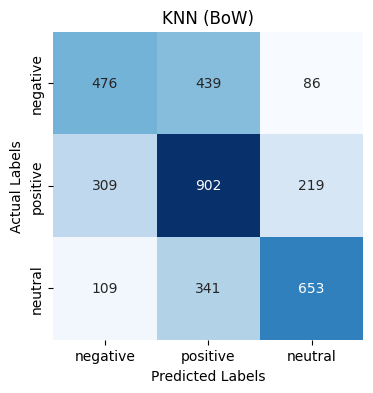

In [69]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_bow_final, y_pred_knn_test)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive', 'neutral'], yticklabels=['negative', 'positive', 'neutral'], cbar=False)
plt.title('KNN (BoW)')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [70]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(weights='distance', n_neighbors=3, metric='cosine')
model_knn.fit(X_train_w2v_final, y_train_w2v_final)

KNeighborsClassifier(metric='cosine', n_neighbors=3, weights='distance')

In [71]:
y_pred_knn_test = model_knn.predict(X_test_w2v_final)
print(f"Accuracy: {accuracy_score(y_test_w2v_final, y_pred_knn_test):.4f}")
print(classification_report(y_test_w2v_final, y_pred_knn_test, target_names=['negative', 'positive', 'neutral']))

Accuracy: 0.5020
              precision    recall  f1-score   support

    negative       0.43      0.45      0.44      1001
    positive       0.49      0.48      0.49      1430
     neutral       0.57      0.57      0.57      1103

    accuracy                           0.50      3534
   macro avg       0.50      0.50      0.50      3534
weighted avg       0.50      0.50      0.50      3534



# MLP

In [73]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [74]:
y_train_tfidf_final = pd.get_dummies(y_train_tfidf_final).values

In [75]:
model = Sequential()

model.add(Dense(units=128, input_dim=X_train_tfidf_final.shape[1], activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2025-11-02 06:39:28.013142: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,579 (2.47 MB)

 Trainable params: 648,579 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

In [77]:
model_history = model.fit(X_train_tfidf_final, y_train_tfidf_final, epochs=100, batch_size=32, validation_split=0.33, callbacks=[early_stopping])

Epoch 1/100
576/576 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5042 - loss: 0.9796 - val_accuracy: 0.6953 - val_loss: 0.7201
Epoch 2/100
576/576 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7383 - loss: 0.6515 - val_accuracy: 0.7031 - val_loss: 0.7083
Epoch 3/100
576/576 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7919 - loss: 0.5390 - val_accuracy: 0.6968 - val_loss: 0.7387
Epoch 4/100
576/576 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8306 - loss: 0.4605 - val_accuracy: 0.6900 - val_loss: 0.8013
Epoch 5/100
576/576 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8633 - loss: 0.3878 - val_accuracy: 0.6825 - val_loss: 0.8598
Epoch 6/100
576/576 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8844 - loss: 0.3249 - val_accuracy: 0.6750 - val_loss: 0.9613
Epoch 7/100
576/576 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9061 - loss: 0.2769 - val_accuracy: 0.6757 - val_loss: 1.0286
Epoch 8/100
576/576 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9208 - loss: 0.2368 - val_accu

In [78]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred_proba = model.predict(X_test_tfidf_final)
y_pred_final = np.argmax(y_pred_proba, axis=1)
accuracy = accuracy_score(y_test_tfidf_final, y_pred_final)
print(f"Accuracy: {accuracy:.4f}\n")
report = classification_report(
    y_test_tfidf_final,
    y_pred_final,
    target_names=['negative', 'neutral', 'positive']
)
print(report)

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.7020

              precision    recall  f1-score   support

    negative       0.72      0.68      0.70      1001
     neutral       0.64      0.70      0.67      1430
    positive       0.78      0.73      0.75      1103

    accuracy                           0.70      3534
   macro avg       0.71      0.70      0.71      3534
weighted avg       0.71      0.70      0.70      3534



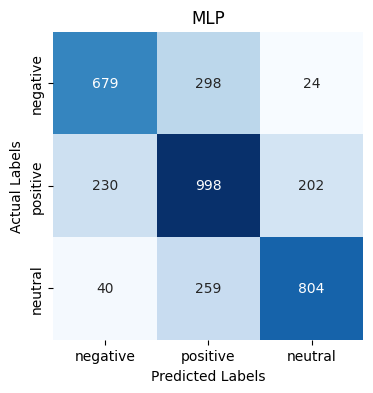

In [79]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_tfidf_final, y_pred_final)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive', 'neutral'], yticklabels=['negative', 'positive', 'neutral'], cbar=False)
plt.title('MLP')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Metrics Plots

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import pandas as pd

# Evaluate all models on validation set
y_pred_lr_tfidf = model_lr_tfidf.predict(X_test_tfidf_final)
y_pred_xgb_tfidf = model_xgb_tfidf.predict(X_test_tfidf_final)
y_pred_rf = model_rf.predict(X_test_tfidf_final)
y_pred_svm = model_svm.predict(X_test_tfidf_final)
y_pred_knn = model_knn.predict(X_test_bow_final)

# Store accuracies
accuracies = {
    "Logistic Regression": accuracy_score(y_test_tfidf_final, y_pred_lr_tfidf),
    "XGBoost": accuracy_score(y_test_tfidf_final, y_pred_xgb_tfidf),
    "Random Forest": accuracy_score(y_test_tfidf_final, y_pred_rf),
    "SVM": accuracy_score(y_test_tfidf_final, y_pred_svm),
    "KNN": accuracy_score(y_test_bow_final, y_pred_knn)
}

# Convert to DataFrame for seaborn
df_acc = pd.DataFrame(list(accuracies.items()), columns=["Model", "Accuracy"])

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="Accuracy", data=df_acc, palette="Blues")
plt.title("Model Accuracies")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.show()


In [81]:
# Plot of Metrics
from sklearn.metrics import precision_score, recall_score, f1_score

metrics = []
for name, y_pred in [
    ("Logistic Regression", y_pred_lr_tfidf),
    ("XGBoost", y_pred_xgb_tfidf),
    ("Random Forest", y_pred_rf),
    ("SVM", y_pred_svm),
    ("KNN", y_pred_knn)
]:
    metrics.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test_tfidf_final, y_pred),
        "Precision": precision_score(y_test_tfidf_final, y_pred, average='weighted'),
        "Recall": recall_score(y_test_tfidf_final, y_pred, average='weighted'),
        "F1": f1_score(y_test_tfidf_final, y_pred, average='weighted')
    })

df_metrics = pd.DataFrame(metrics)
df_metrics_melted = df_metrics.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="Score", hue="Metric", data=df_metrics_melted, palette="Blues")
plt.title("Comparison of Models Across Metrics")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.show()

NameError: name 'y_pred_rf' is not defined